In [1]:
from collections import deque
import torch
torch.manual_seed(1)
import numpy as np
import ddpg
from importlib import reload
reload(ddpg)
from ddpg import DDPG
import matplotlib.pyplot as plt
import re, sys,subprocess, socket
import time

In [2]:
#make it generalizable to any number of weights
def calc_reward(w, x, num_tunnels):
  cost = -0.1 * torch.dot(w, x[num_tunnels:num_tunnels*2])
  net_perf = torch.dot(w, x[0:num_tunnels])
  err = torch.abs(w - x[num_tunnels*2:num_tunnels*3])
  user_pref = -torch.sum(err)
  return net_perf + user_pref + cost
  # return net_perf + cost #if user_pref is equal for all

def calculate_TWA(rtts, gain, size, alpha, C, prev_weights):
    twa_weights = []
    for i in range(len(rtts)):
        weight = size/(float(rtts[i])*1000) * C * gain
        twa_weights.append(alpha*weight + (1-alpha)*prev_weights[i])
    return [1/(float(rtt)*1000) for rtt in rtts]
    return twa_weights

def initialize_ecmp_weights():
    subprocess.run(['.././make-ecmp-route.sh'])

def adjust_ecmp_weights(new_weights):
    #convert weight into integer percentages understood by script - doesn't allow weight of 0?
    #+1 because weights can't be 0, am i sure ecmp is doing this right? how do weights of 1 1 1 1 work?
    w = [str(round(w.item()*100)+1) for w in new_weights]
    subprocess.run(['sudo', '.././adjust-ecmp-weights.sh', w[0], w[1], w[2], w[3]])
    return w

#server used when I had to communicate between client and router
def start_server(host='10.10.0.201', port=7007):
    server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_socket.bind((host, port))
    server_socket.listen(5)
    print(f"Server listening on {host}:{port}")
    return server_socket

#to generate iperf traffic with given list of flows (weights) per "tunnel"
def generate_iperf(ips, weights, port):
    processes = []
    for i in range(len(ips)):
        cmd = ['iperf3', '-c', ips[i], '-t', '10', '-i', '1', '-P', weights[i], '-p', port]
        processes.append(subprocess.Popen(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE))
    return processes

#terminate existing iperf generators to generate new flows per tunnel
def terminate(processes):
    for process in processes:
        process.terminate()
        #clean way to ensure all terminate, can explore other methods if it's too slow though
        process.wait()
        if process.poll() is None:
            print("process unfinished")
    
def ping(ip):
    try:
        # Execute the ping command
        result = subprocess.run(['ping', '-c', '1', ip], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        # print(result)
        # Extract the time using regular expression
        match = re.search(r'time=(\d+\.\d+) ms', result.stdout)
        if match:
            return match.group(1)
        else:
            return None
    except Exception as e:
        print(f"Error pinging {ip}: {e}")
        return None

In [3]:
# problem parameters
num_tunnels = 4
state_dim = 3 * num_tunnels
action_dim = 1 * num_tunnels
# IP addresses to ping
ips = ['192.168.1.0', '192.168.1.1', '192.168.1.2', '192.168.1.3']
#iperf server port
port = '5201'


num_agents = 20

# hyperparameters
hidden_dim = 12
batch_size = 256
actor_lr = 1e-4
critic_lr = 2e-4
tau = 0.001
gamma = 0.9
epsilon = 0.1
# use Gaussian noise?
noise_scale = 0.5*torch.randn(action_dim)
# noise_scale = 0.5
noise_decay = 0.998

episodes = 50
max_steps = 100

#alpha for TWA
alpha = 0.5

In [4]:
# intialize learning agent
agent = DDPG(state_dim, action_dim, hidden_dim=hidden_dim, buffer_size=8000, batch_size=batch_size,
               actor_lr=actor_lr, critic_lr=critic_lr, tau=tau, gamma=gamma)
cost = torch.FloatTensor([10,10,40,40])
user_pref  = torch.FloatTensor([0.4,0.4,0.1,0.1])
fixed_x = torch.cat((cost, user_pref))
twa_weights = [0,0,0,0]
start_weights = torch.tensor([0.25,0.25,0.25,0.25])
start_weights = [str(round(w.item()*100)+1) for w in start_weights]

rewards_window = deque(maxlen=100)
rewards = []
actor_losses = []
# critic_losses = []
states = []
actions = []

# server_socket = start_server(port=7008)
# conn, addr = server_socket.accept()
# print(f"Connection from {addr}")

processes = generate_iperf(ips,start_weights,port)
rtts = [ping(ip) for ip in ips]
print(rtts)
if None in rtts:
     print("Failed to retrieve ping times for one or more IP addresses.")
     sys.exit(1)
time.sleep(0.5)
twa_weights = calculate_TWA(rtts,1,64,alpha,1,twa_weights)
state = torch.cat((torch.tensor(twa_weights), fixed_x))

for episode in range(episodes):
     # agent_rewards = np.zeros(num_agents)
     tot_reward = 0
     # state = performance_raw_weights
     actor_step_losses = []
     #critic_step_losses = []
     for steps in range(max_steps):
          action = agent.act(state, noise_scale)
          action_weights = [str(round(w.item()*100)+1) for w in action]
          #kill processes and start new ones with calculated flows (weights)
          terminate(processes)
          processes = generate_iperf(ips,action_weights,port)
          #should reward be calculated with the prev state or the next state for better results?
          reward = calc_reward(action, state, num_tunnels=4) 
          # done = int(steps == max_steps - 1)
          rtts = [ping(ip) for ip in ips]
          if None in rtts:
               print("Failed to retrieve ping times for one or more IP addresses.")
               sys.exit(1)
          time.sleep(0.1)
          twa_weights = calculate_TWA(rtts,1,64,alpha,1,twa_weights)
          next_state = torch.cat((torch.tensor(twa_weights), fixed_x))
          # for i in range(num_agents):
          #      agent.store_transition(state, action, reward, next_state, done)
          # agent.store_transition(state, action, reward, next_state, done)
          # actor_loss, critic_loss = agent.learn()
          # actor_loss = -reward * epsilon
          actor_loss = -reward
          agent.actor.optimizer.zero_grad()
          actor_loss.backward()
          agent.actor.optimizer.step()

          if actor_loss is not None:
               actor_step_losses.append(actor_loss.detach().numpy())
               #critic_step_losses.append(critic_loss.detach().numpy())
          
          state = next_state
          # agent_rewards += reward.detach().numpy()
          tot_reward += reward.detach().numpy()
          noise_scale *= noise_decay
          
     states.append(twa_weights)
     actions.append(action.detach().numpy())
     #avg_reward = np.mean(agent_rewards)
     avg_reward = tot_reward/max_steps
     rewards_window.append(avg_reward)
     rewards.append(avg_reward)

     if actor_step_losses:
          actor_losses.append(np.mean(actor_step_losses))
          #critic_losses.append(np.mean(critic_step_losses))

     if episode % 10 == 0:
          print(action)
          print(f'Episode {episode}, Reward: {avg_reward:.2f}, Avg Reward: {np.mean(rewards_window):.2f}')
     
#save final network
torch.save(agent.actor.state_dict(), 'final_models/actor_final.pth')
torch.save(agent.critic.state_dict(), 'final_models/critic_final.pth')

['0.445', '0.453', '0.457', '0.474']
tensor([0.3141, 0.2329, 0.0632, 0.3898], grad_fn=<DivBackward0>)
Episode 0, Reward: -3.70, Avg Reward: -3.70
tensor([0.5377, 0.4164, 0.0072, 0.0387], grad_fn=<DivBackward0>)
Episode 10, Reward: -1.45, Avg Reward: -1.81
tensor([0.5531, 0.4386, 0.0014, 0.0070], grad_fn=<DivBackward0>)
Episode 20, Reward: -1.41, Avg Reward: -1.62
tensor([5.5737e-01, 4.4065e-01, 3.6402e-04, 1.6130e-03],
       grad_fn=<DivBackward0>)
Episode 30, Reward: -1.40, Avg Reward: -1.55
tensor([5.2261e-01, 4.7667e-01, 1.3546e-04, 5.8610e-04],
       grad_fn=<DivBackward0>)
Episode 40, Reward: -1.40, Avg Reward: -1.52


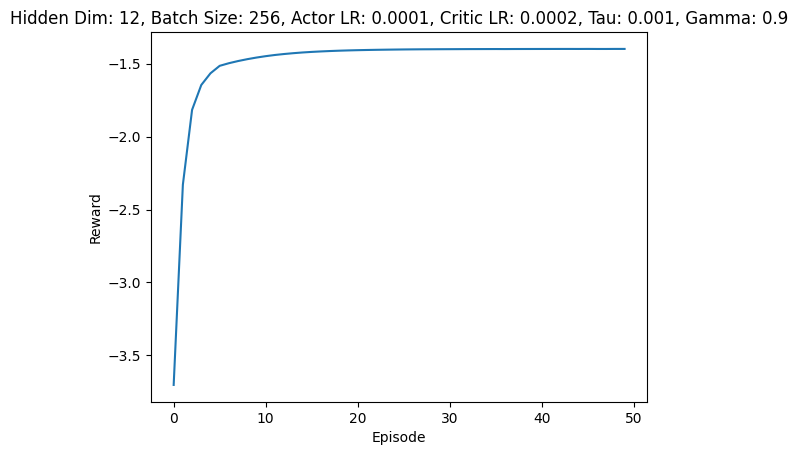

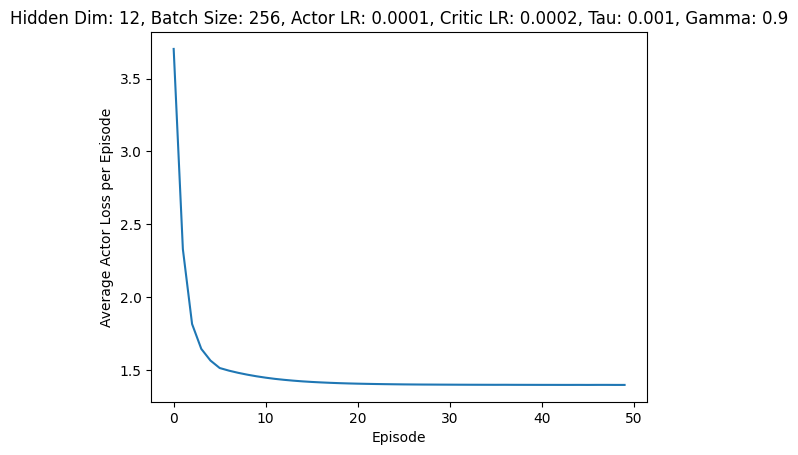

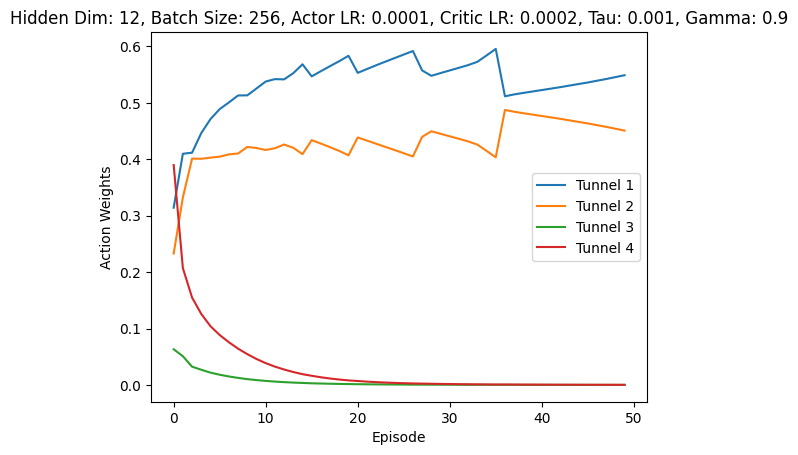

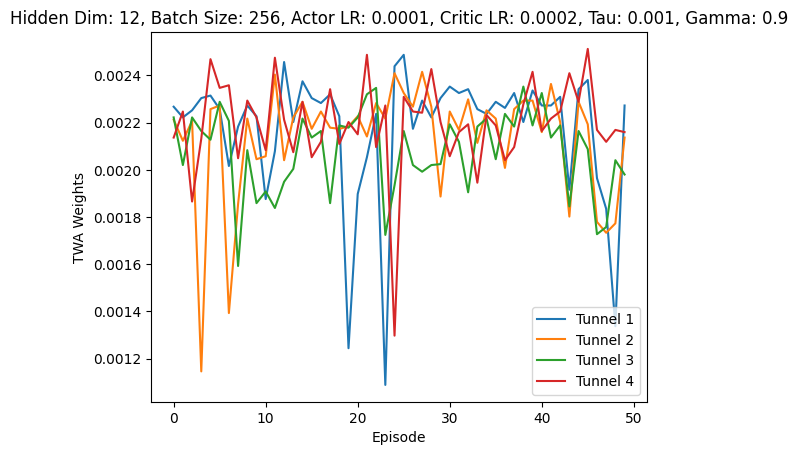

In [5]:
hyperparameter_title = f'Hidden Dim: {hidden_dim}, Batch Size: {batch_size}, Actor LR: {actor_lr}, Critic LR: {critic_lr}, Tau: {tau}, Gamma: {gamma}'
# plot reward
rewards_graph = rewards
plt.plot(rewards_graph)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.show()

# plot actor loss
plt.plot(actor_losses)
plt.ylabel('Average Actor Loss per Episode')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.show()

# plot critic loss
# plt.plot(critic_losses)
# plt.ylabel('Average Critic Loss per Episode')
# plt.xlabel('Episode')
# plt.title(hyperparameter_title)
# plt.show()

# plot actions
actions = np.array(actions)
plt.plot(actions[:,0])
plt.plot(actions[:,1])
plt.plot(actions[:,2])
plt.plot(actions[:,3])
plt.ylabel('Action Weights')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.legend(['Tunnel 1', 'Tunnel 2', 'Tunnel 3', 'Tunnel 4'])
plt.show()

# plot states
states = np.array(states)
plt.plot(states[:,0])
plt.plot(states[:,1])
plt.plot(states[:,2])
plt.plot(states[:,3])
plt.ylabel('TWA Weights')
plt.xlabel('Episode')
plt.title(hyperparameter_title)
plt.legend(['Tunnel 1', 'Tunnel 2', 'Tunnel 3', 'Tunnel 4'])
plt.show()

In [6]:
test_x = fixed_x
state = torch.cat((torch.tensor([1,0,0,0]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())
test_x = fixed_x
state = torch.cat((torch.tensor([0,1,0,0]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())
test_x = fixed_x
state = torch.cat((torch.tensor([0,0,1,0]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())
test_x = fixed_x
state = torch.cat((torch.tensor([0,0,0,1]), test_x))
action = agent.act(state)
print(action)
print(calc_reward(action, state, num_tunnels=4).item())

tensor([5.4713e-01, 4.5255e-01, 6.3957e-05, 2.5815e-04],
       grad_fn=<DivBackward0>)
-0.8531941175460815
tensor([5.3489e-01, 4.6476e-01, 6.6332e-05, 2.8425e-04],
       grad_fn=<DivBackward0>)
-0.9355899095535278
tensor([5.6577e-01, 4.3392e-01, 6.7492e-05, 2.4317e-04],
       grad_fn=<DivBackward0>)
-1.4002431631088257
tensor([5.4827e-01, 4.5141e-01, 6.6325e-05, 2.6249e-04],
       grad_fn=<DivBackward0>)
-1.4000663757324219
